In [7]:
# data manipulation 
import numpy as np
import pandas as pd

from datetime import datetime
import itertools as it

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics
import prepare
import math

import acquire
# data visualization 
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

from acquire import get_store_data
from prepare import prep_store_data, split_store_data


In [8]:
df= pd.read_csv('saas.csv')

In [9]:
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [10]:
target_vars=['Amount']

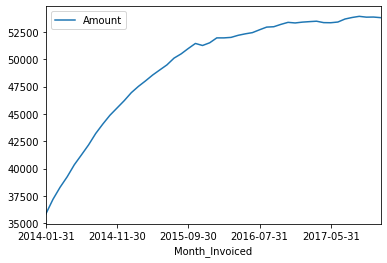

In [11]:
df = df.groupby(['Month_Invoiced'])['Amount'].sum().reset_index()
df.plot(x='Month_Invoiced', y='Amount')

#### 1. Split data (train/test) and resample by any period, except daily, and aggregate using the sum.

In [12]:
prepare.split_store_data(df)

(    index Month_Invoiced   Amount
 0       0     2014-01-31  35850.0
 1       1     2014-02-28  37190.0
 2       2     2014-03-31  38295.0
 3       3     2014-04-30  39255.0
 4       4     2014-05-31  40355.0
 5       5     2014-06-30  41255.0
 6       6     2014-07-31  42170.0
 7       7     2014-08-31  43210.0
 8       8     2014-09-30  44075.0
 9       9     2014-10-31  44880.0
 10     10     2014-11-30  45545.0
 11     11     2014-12-31  46210.0
 12     12     2015-01-31  46945.0
 13     13     2015-02-28  47520.0
 14     14     2015-03-31  48025.0
 15     15     2015-04-30  48560.0
 16     16     2015-05-31  49025.0
 17     17     2015-06-30  49485.0
 18     18     2015-07-31  50105.0
 19     19     2015-08-31  50495.0
 20     20     2015-09-30  50985.0
 21     21     2015-10-31  51445.0
 22     22     2015-11-30  51260.0
 23     23     2015-12-31  51505.0
 24     24     2016-01-31  51955.0
 25     25     2016-02-29  51955.0
 26     26     2016-03-31  52000.0
 27     27     2016-

In [30]:
X = df.Month_Invoiced
y = df.Amount

train, test = split_store_data(df, train_prop=.66)

print('Observations: %d' % (len(df)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))



Observations: 48
Training Observations: 31
Testing Observations: 17


In [31]:
df['Month_Invoiced'] = pd.to_datetime(df['Month_Invoiced'])

In [32]:
train = train.set_index('Month_Invoiced')
test = test.set_index('Month_Invoiced')

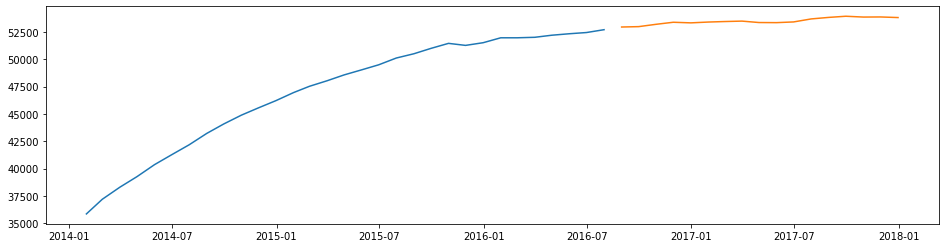

In [33]:
for var in range(len(target_vars)):
    plt.figure(figsize=(16, 4))
    plt.plot(train[target_vars[var]])
    plt.plot(test[target_vars[var]])
    plt.show()

### 2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:

In [50]:
yhat = pd.DataFrame(test[target_vars])

In [51]:
for var in target_vars:
    yhat[var] = int(train[var][-1:])

In [52]:
yhat.head()

,Amount
Month_Invoiced,
2016-08-31,52695
2016-09-30,52695
2016-10-31,52695
2016-11-30,52695
2016-12-31,52695


In [57]:
def append_eval_df(model_type, target_vars, train = train, test = test):
    temp_eval_df = pd.concat([pd.DataFrame([[model_type, i, 'mse', evaluate(target_var = i, 
                                                                            train = train, 
                                                                            test = test, 
                                                                            output=False)[0]],
                                            [model_type, i, 'rmse', evaluate(target_var = i, 
                                                                             train = train, 
                                                                             test = test, 
                                                                             output=False)[1]]],
                                           columns=['model_type', 'target_var', 'metric', 'value']) 
                              for i in target_vars], ignore_index=True)
    return eval_df.append(temp_eval_df, ignore_index=True)

def evaluate(target_var, train = train, test = test, output=True):
    mse = metrics.mean_squared_error(test[target_var], yhat[target_var])
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse

def plot_and_eval(target_vars, train = train, test = test, metric_fmt = '{:.2f}', linewidth = 4):
    if type(target_vars) is not list:
        target_vars = [target_vars]

    plt.figure(figsize=(16, 8))
    plt.plot(train[target_vars],label='Train', linewidth=1)
    plt.plot(test[target_vars], label='Test', linewidth=1)

    for var in target_vars:
        mse, rmse = evaluate(target_var = var, train = train, test = test, output=False)
        plt.plot(yhat[var], linewidth=linewidth)
        print(f'{var} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse))

    plt.show()
    


##### Simple Average

In [58]:
for var in target_vars:
    yhat[var] = train[var].mean()

Amount -- MSE: 41153969.15 RMSE: 6415.14


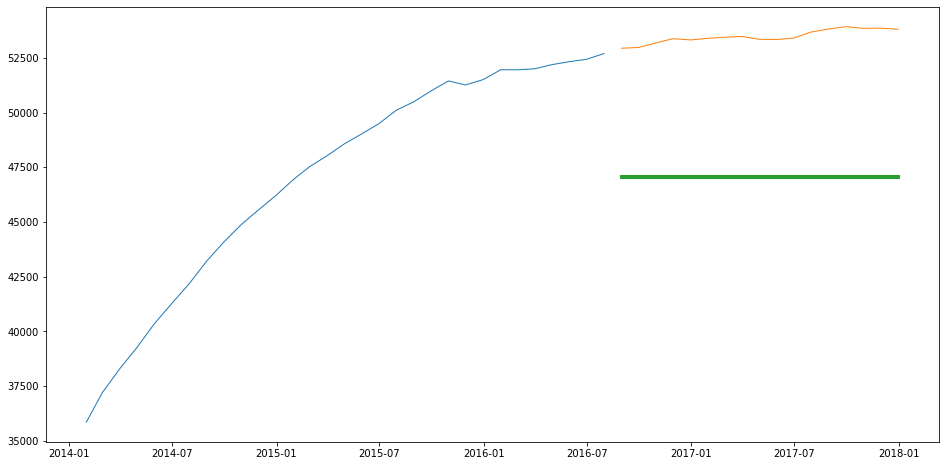

In [59]:
plot_and_eval(target_vars, train = train, test = test)

In [61]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'metric', 'value'])
eval_df

,model_type,target_var,metric,value


In [62]:
eval_df = append_eval_df(model_type='simple_average', target_vars=target_vars, train = train, test = test)
eval_df

,model_type,target_var,metric,value
0,simple_average,Amount,mse,4.115397e+07
1,simple_average,Amount,rmse,6.415136e+03


#### Moving Average

In [63]:
periods = 30
for var in target_vars:
    yhat[var] = train[var].rolling(periods).mean().iloc[-1]

Amount -- MSE: 36499939.71 RMSE: 6041.52


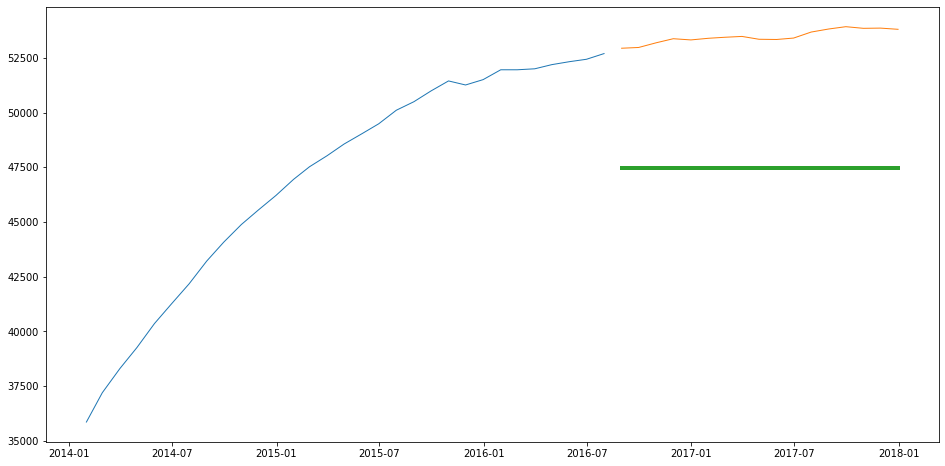

In [64]:
plot_and_eval(target_vars, train = train, test = test)

Amount -- MSE: 36499939.71 RMSE: 6041.52


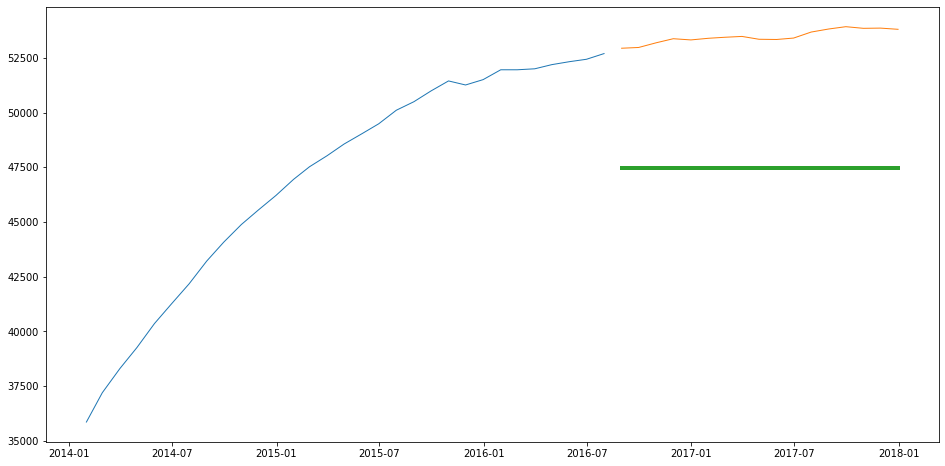


rolling averge period: 1
Amount
MSE:  701116.1764705882
RMSE: 837.3268038648878

rolling averge period: 4
Amount
MSE:  1226783.9154411764
RMSE: 1107.6027787258283

rolling averge period: 12
Amount
MSE:  3006478.604983669
RMSE: 1733.9200111261387

rolling averge period: 26
Amount
MSE:  22179323.548990607
RMSE: 4709.492918456361

rolling averge period: 52
Amount


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

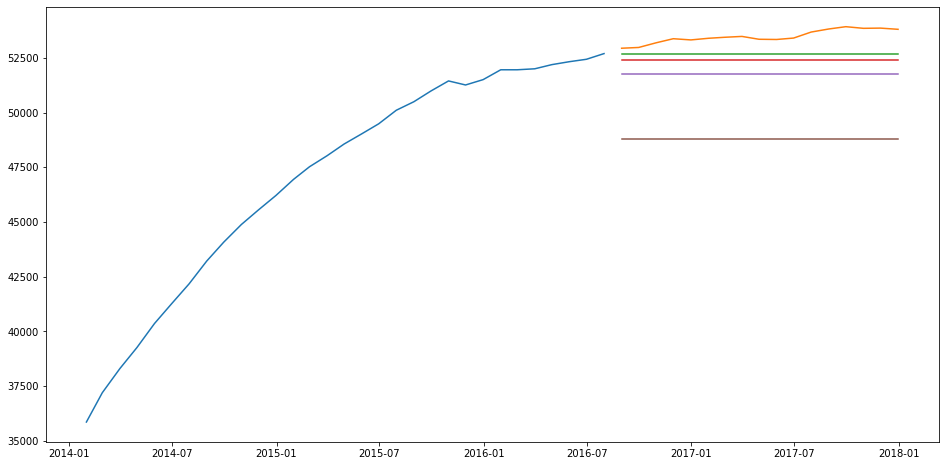

In [66]:
periods = 30
periods = 30
for var in target_vars:
    yhat[var] = train[var].rolling(periods).mean().iloc[-1]

plot_and_eval(target_vars, train, test)
eval_df = append_eval_df(model_type='moving_average', target_vars=target_vars, train = train, test = test)

plt.figure(figsize=(16, 8))
plt.plot(train[target_vars],label='Train')
plt.plot(test[target_vars], label='Test')
period_vals = [1, 4, 12, 26, 52, 104]
for p in period_vals:
    for var in target_vars:
        yhat[var] = train[var].rolling(p).mean().iloc[-1]
        plt.plot(yhat[var])
        print('\nrolling averge period:',p)
        print(var)
        evaluate(var, train = train, test = test)

#### 3. Holt's Linear Trend

Amount 



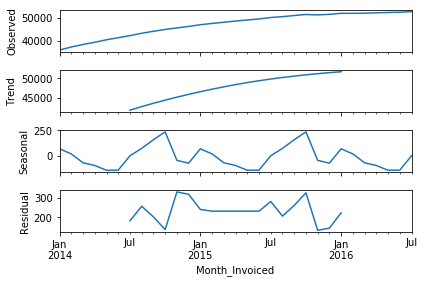

In [67]:
import statsmodels.api as sm

for var in target_vars:
    print(var,'\n')
    _ = sm.tsa.seasonal_decompose(train[var].resample('M').mean()).plot()
    plt.show()

Amount -- MSE: 9901225.07 RMSE: 3146.62


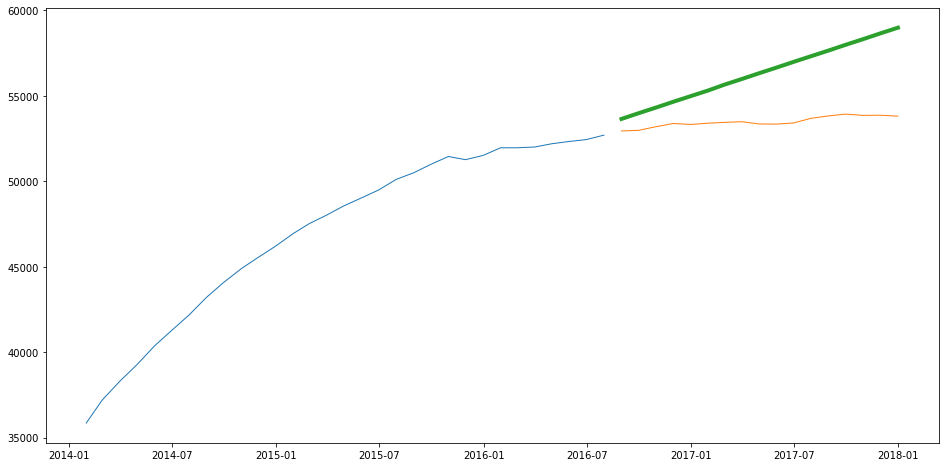

In [68]:
from statsmodels.tsa.api import Holt

for var in target_vars:
    model = Holt(train[var]).fit(smoothing_level=.3, smoothing_slope=.1, optimized=False)
    yhat[var] = pd.DataFrame(model.forecast(test[var].shape[0]), columns=[var])

plot_and_eval(target_vars, train, test)
eval_df = append_eval_df(model_type='holts_linear_trend', target_vars=target_vars, train = train, test = test)

Amount -- MSE: 15259748.55 RMSE: 3906.37


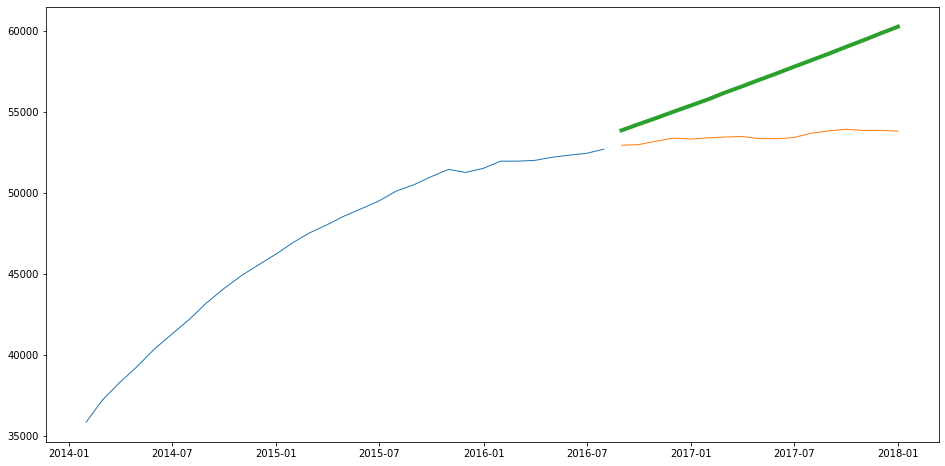

In [69]:
for var in target_vars:
    model = Holt(train[var], exponential=True).fit(smoothing_level=.3, smoothing_slope=.1, optimized=False)
    yhat[var] = pd.DataFrame(model.forecast(test[var].shape[0]), columns=[var])

plot_and_eval(target_vars, train, test)
eval_df = append_eval_df(model_type='holts_exponential_trend', target_vars=target_vars, train = train, test = test)

#### 4. Predicting Based on the Previous Cycle

Text(0, 0.5, 'RMSE')

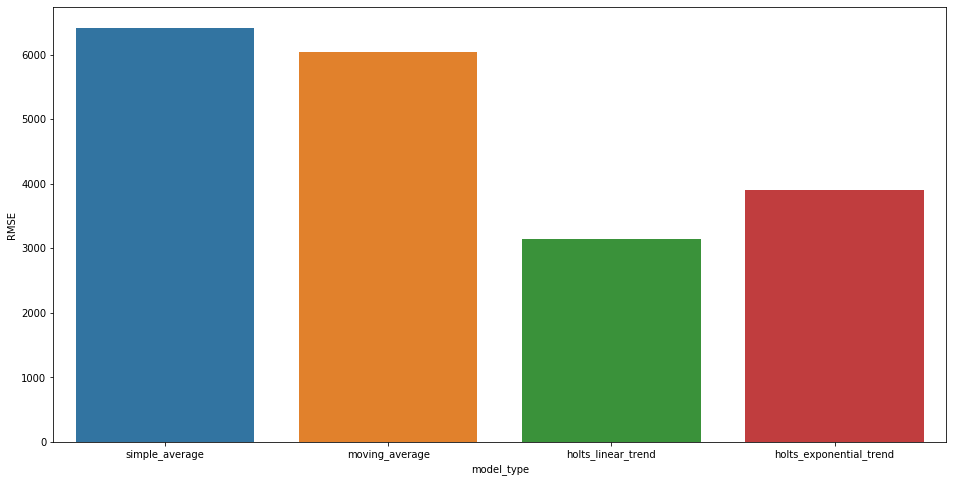

In [70]:
x = eval_df[eval_df.metric == 'rmse']['model_type']
y = eval_df[eval_df.metric == 'rmse']['value']
plt.figure(figsize=(16, 8))
sns.barplot(x, y)
plt.ylabel('RMSE')